In [1]:
import argparse
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow import keras
import zlib
from platform import python_version
import tensorflow_model_optimization as tfmot   
import tempfile
print(f"Python version used to excute the code is {python_version()}")



Python version used to excute the code is 3.7.11


In [2]:
# ######################################################## Input Parameters #########################################################
# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, required=True, help='model name')
# parser.add_argument('--mfcc', action='store_true', help='use MFCCs')
# args = parser.parse_args()

######################################################## Inputs and model selection  #########################################################

In [15]:
version = "a"
m = "ds_cnn"   # model name [ mlp , cnn , ds_cnn  ]
mfcc = True    # True --> excute mfcc , False --> excute STFT
alpha = 1
sparsity = 0.9
Structured = True

if Structured == True :
    model_version = f"_V_{version}_alpha={alpha}"
else :
    alpha = 1
    model_version = f"_V_{version}_Sparcity ={sparsity}"
mymodel = m + model_version
TFLITE = mymodel + ".tflite"                                    # path for saving the best model after converted to TF.lite model 
units = 8                                                       # The number of output class [8:without silence , 9 : with silence]

In [4]:

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


# data_dir = os.path.join('.', 'data', 'mini_speech_commands_silence')
# # else:
zip_path = tf.keras.utils.get_file(
    origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
    fname='mini_speech_commands.zip',
    extract=True,
    cache_dir='.', cache_subdir='data')

data_dir = os.path.join('.', 'data', 'mini_speech_commands')

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

total = 8000          # NUMBER OF TOTAL Files Including THE Silence records 

train_files =   filenames[: int(total*0.8)]                                             # filenames[:int(total*0.8)]
val_files = filenames[int(total*0.8): int(total*0.9)]
test_files = filenames[int(total*0.9):]

# with silence ['stop', 'up', 'yes', 'right', 'left', 'no', 'silence', 'down', 'go']
LABELS = np.array(['stop', 'up', 'yes', 'right', 'left', 'no',  'down', 'go'] , dtype = str) 
print (LABELS)
# LABELS = LABELS[LABELS != 'README.md']

['stop' 'up' 'yes' 'right' 'left' 'no' 'down' 'go']


In [13]:
train_files

<tf.Tensor: shape=(6400,), dtype=string, numpy=
array([b'.\\data\\mini_speech_commands\\up\\b7a6f709_nohash_0.wav',
       b'.\\data\\mini_speech_commands\\go\\e7ea8b76_nohash_7.wav',
       b'.\\data\\mini_speech_commands\\up\\f33660af_nohash_1.wav', ...,
       b'.\\data\\mini_speech_commands\\down\\6cb6eee7_nohash_0.wav',
       b'.\\data\\mini_speech_commands\\left\\68effe85_nohash_0.wav',
       b'.\\data\\mini_speech_commands\\stop\\3a7d8872_nohash_0.wav'],
      dtype=object)>

In [5]:
x = tf.strings.split(train_files[0] , os.path.sep)
for path in x :
    print("&" * 100 , "\n" , path.numpy())
    
print(x[-2])

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& 
 b'.'
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& 
 b'data'
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& 
 b'mini_speech_commands'
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& 
 b'up'
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& 
 b'b7a6f709_nohash_0.wav'
tf.Tensor(b'up', shape=(), dtype=string)


######################################################## Create the SignalGenerator #########################################################

In [6]:

class SignalGenerator:
    def __init__(self, labels, sampling_rate, frame_length, frame_step,
            num_mel_bins=None, lower_frequency=None, upper_frequency=None,
            num_coefficients=None, mfcc=False):
        self.labels = labels
        self.sampling_rate = sampling_rate                                             # 16000  
        self.frame_length = frame_length                                               # 640 
        self.frame_step = frame_step                                                   # 320 
        self.num_mel_bins = num_mel_bins                                               # 40 
        self.lower_frequency = lower_frequency                                         # 20 
        self.upper_frequency = upper_frequency                                         # 4000
        self.num_coefficients = num_coefficients                                       # 10 
        num_spectrogram_bins = (frame_length) // 2 + 1                                  # ( frame size // 2 ) + 1 

        '''
        STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False}
        MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10}
        '''

        if mfcc is True:                                                                # Remember we need to compute this matrix once so it will be a class argument 
            self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
                    self.num_mel_bins, num_spectrogram_bins, self.sampling_rate,
                    self.lower_frequency, self.upper_frequency)
            self.preprocess = self.preprocess_with_mfcc
        else:
            self.preprocess = self.preprocess_with_stft

    def read(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        label = parts[-2]                                  # -1 is audio.wav so 
        label_id = tf.argmax(label == self.labels)
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary)
        audio = tf.squeeze(audio, axis=1)

        return audio, label_id

    def pad(self, audio):
        # Padding for files with less than 16000 samples
        zero_padding = tf.zeros([self.sampling_rate] - tf.shape(audio), dtype=tf.float32)     # if the shape of the audio is already = 16000 (sampling rate) we will add nothing 

        # Concatenate audio with padding so that all audio clips will be of the  same length
        audio = tf.concat([audio, zero_padding], 0)
        # Unify the shape to the sampling frequency (16000 , )
        audio.set_shape([self.sampling_rate])

        return audio

    def get_spectrogram(self, audio):
        stft = tf.signal.stft(audio, frame_length=self.frame_length,
                frame_step=self.frame_step, fft_length=self.frame_length)
        spectrogram = tf.abs(stft)

        return spectrogram

    def get_mfccs(self, spectrogram):
        mel_spectrogram = tf.tensordot(spectrogram,
                self.linear_to_mel_weight_matrix, 1)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
        mfccs = mfccs[..., :self.num_coefficients]

        return mfccs

    def preprocess_with_stft(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio)
        spectrogram = tf.expand_dims(spectrogram, -1)
 
   # expand_dims will not add or reduce elements in a tensor, it just changes the shape by adding 1 to dimensions. For example, a vector with 10 elements could be treated as a 10x1 matrix.
    #The situation I have met to use expand_dims is when I tried to build a ConvNet to classify grayscale images. The grayscale images will be loaded as matrix of size [320, 320]. However,
    #tf.nn.conv2d require input to be [batch, in_height, in_width, in_channels], 
    # where the in_channels dimension is missing in my data which in this case should be 1. So I used expand_dims to add one more dimension.
    
        spectrogram = tf.image.resize(spectrogram, [32, 32])

        return spectrogram, label

    def preprocess_with_mfcc(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio)
        mfccs = self.get_mfccs(spectrogram)
        mfccs = tf.expand_dims(mfccs, -1)

        return mfccs, label

    def make_dataset(self, files, train):
        ds = tf.data.Dataset.from_tensor_slices(files)
        ds = ds.map(self.preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE) # better than 4 tf.data.experimental.AUTOTUNE
        ds = ds.batch(32)
        ds = ds.cache()
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds


######################################################## Options for MFCC & STFT #########################################################

In [7]:
STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False}
MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10}
if mfcc is True:
    options = MFCC_OPTIONS
    strides = [2, 1]
else:
    options = STFT_OPTIONS
    strides = [2, 2]



######################################################## Generate Data set splits #########################################################

In [8]:
## We need the silence file to complete this 

In [9]:
generator = SignalGenerator(LABELS, 16000, **options)
train_ds = generator.make_dataset(train_files, True)
val_ds = generator.make_dataset(val_files, False)
test_ds = generator.make_dataset(test_files, False)

In [10]:
it = iter(val_ds)

In [12]:
inp , label = next(it)
print(inp.shape)
print(label[0])

(32, 49, 10, 1)
tf.Tensor(0, shape=(), dtype=int64)


########################################################  building the models ########################################################

In [16]:


mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = int(256 *alpha), activation='relu' , name =  "Dense-1" ),
    tf.keras.layers.Dense(units = int(256 *alpha), activation='relu', name =  "Dense-2"),
    tf.keras.layers.Dense(units = int(256 *alpha), activation='relu', name =   "Dense-3" ),
    tf.keras.layers.Dense(units = units , name =  "Output-Layer")                                   # change to 9 if silence included 
])

cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=int(128 *alpha), kernel_size=[3,3], strides=strides, use_bias=False , name = "Conv2D-1"),
    tf.keras.layers.BatchNormalization(momentum=0.1 , name = "Btch_Norm-1"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=int(128 *alpha), kernel_size=[3,3], strides=[1,1], use_bias=False , name = "Conv2D-2"),
    tf.keras.layers.BatchNormalization(momentum=0.1 , name = "Btch_Norm-2"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=int(128 *alpha), kernel_size=[3,3], strides=[1,1], use_bias=False , name = "Conv2D-3"),
    tf.keras.layers.BatchNormalization(momentum=0.1 , name = "Btch_Norm-3"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling2D( name =  "GlobalAveragePooling-Layer"),
    tf.keras.layers.Dense(units = units, name =  "Output-Layer")
])

ds_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=int(256 *alpha), kernel_size=[3,3], strides=strides, use_bias=False, name = "Conv2D-1"),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, name = "DepthwiseConv2D-1"),
    tf.keras.layers.Conv2D(filters=int(256 *alpha), kernel_size=[1,1], strides=[1,1], use_bias=False, name = "Conv2D-2"),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, name = "DepthwiseConv2D-2"),
    tf.keras.layers.Conv2D(filters=int(256 *alpha), kernel_size=[1,1], strides=[1,1], use_bias=False, name = "Conv2D-3"),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling2D( name =  "GlobalAveragePooling-Layer"),
    tf.keras.layers.Dense(units = units, name =  "Output-Layer")
])


MODELS = {'mlp'+ model_version : mlp, 'cnn'+ model_version: cnn, 'ds_cnn'+ model_version: ds_cnn}
print(MODELS.keys())

dict_keys(['mlp_V_a_alpha=1', 'cnn_V_a_alpha=1', 'ds_cnn_V_a_alpha=1'])


######################################################## Define optimizer & Losses & Metrics ########################################################

In [17]:

model = MODELS[mymodel]              # initiate the selected model 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]



########################################################################################################################################################################
if Structured == False :                                # if False -->  Magnitude Based Pruning is applied 
    input_shape = (32, 49, 10, 1)
    model.build(input_shape)
    # Define the sparsity scheduler
    pruning_params = {'pruning_schedule':
    tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.30,
    final_sparsity=sparsity,
    begin_step=len(train_ds)*5,
    end_step=len(train_ds)*15)}

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    model = prune_low_magnitude(model, **pruning_params)
    
    # Define the pruning callback
    PruningCallback = [tfmot.sparsity.keras.UpdatePruningStep()]
########################################################################################################################################################################    
################### Compiling the model :

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

######################################################## check points depending on preprocessing STFT , MFCC 
if mfcc is False:
    checkpoint_filepath = f'./checkpoints/stft/chkp_best_{mymodel}'

else:
    checkpoint_filepath = f'./checkpoints/mfcc/chkp_best_{mymodel}'
    
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,           
    monitor='val_sparse_categorical_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
    save_freq='epoch')

######################################################## Model Training ########################################################

In [18]:
if Structured == True :
    history = model.fit(train_ds, epochs=10,   validation_data=val_ds,callbacks=[model_checkpoint_callback ])
else :
    history = model.fit(train_ds, epochs=10,   validation_data=val_ds,callbacks=[model_checkpoint_callback,PruningCallback])
    # model = tf.keras.models.load_model(filepath = checkpoint_filepath)
    model_to_export = tfmot.sparsity.keras.strip_pruning(model)



Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.2456 - sparse_categorical_accuracy: 0.6036
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.81500, saving model to ./checkpoints/mfcc\chkp_best_ds_cnn_V_a_alpha=1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./checkpoints/mfcc\chkp_best_ds_cnn_V_a_alpha=1\assets
200/200 [==============================] - 15s 76ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.6036 - val_loss: 0.7019 - val_sparse_categorical_accuracy: 0.8150
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.6128 - sparse_categorical_accuracy: 0.8330
Epoch 00002: val_sparse_categorical_accuracy improved from 0.81500 to 0.85875, saving model to ./checkpoints/mfcc\chkp_best_ds_cnn_V_a_

In [19]:
############################## Print Model Summary ####################
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 24, 8, 256)        2304      
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 8, 256)        1024      
_________________________________________________________________
re_lu_9 (ReLU)               (None, 24, 8, 256)        0         
_________________________________________________________________
DepthwiseConv2D-1 (Depthwise (None, 22, 6, 256)        2304      
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 22, 6, 256)        65536     
_________________________________________________________________
batch_normalization_4 (Batch (None, 22, 6, 256)        1024      
_________________________________________________________________
re_lu_10 (ReLU)              (None, 22, 6, 256)       

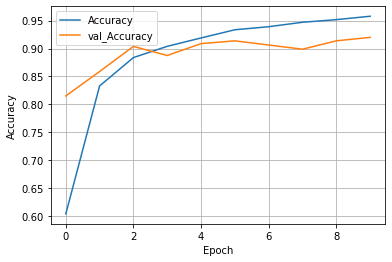

In [20]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(mymodel+".png")

plot_loss(history)

In [29]:
best_model = tf.keras.models.load_model(filepath = checkpoint_filepath )
best_model.evaluate(test_ds)

INFO:tensorflow:Assets written to: best_wo_opt\assets


INFO:tensorflow:Assets written to: best_wo_opt\assets


In [36]:
best_model.evaluate(test_ds)

25/25 [==============================] - 1s 41ms/step - loss: 0.2442 - sparse_categorical_accuracy: 0.9162


[0.24423746764659882, 0.9162499904632568]

In [31]:
converter_best = tf.lite.TFLiteConverter.from_saved_model(checkpoint_filepath)
tflite_model_best = converter_best.convert() 
with open("./models/best.tflite", 'wb') as fp:
    fp.write(tflite_model_best)

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model("best_wo_opt")
# tflite_model = converter.convert() 
# with open("./models/best_wo_opt.tflite", 'wb') as fp:
#     fp.write(tflite_model)

In [34]:
# Compressed = "compressed_"+tflite_model_dir 
with open("./models/compressed_best.tflite", 'wb') as fp:
    tflite_compressed = zlib.compress(tflite_model_best)
    fp.write(tflite_model_best)

In [ ]:

interpreter = tf.lite.Interpreter(model_path="./models/best.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

chunk = 4800
resolution = pyaudio.paInt16
samp_rate = 48000
record_secs = 1 # seconds to record
dev_index = 0 # device index found by p.get_device_info_by_index(ii)
chunks = int((samp_rate / chunk) * record_secs)

length = int(0.040*16000)
stride = int(0.020*16000)
num_mel_bins = 40
spectrogram_width = (16000 - length) // stride + 1
num_spectrogram_bins = length // 2 + 1
num_coefficients = 10
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, 16000, 20, 4000)

buf = BytesIO()

audio = pyaudio.PyAudio() # create pyaudio instantiation
stream = audio.open(format=resolution, rate=samp_rate, channels=1,
                    input_device_index=dev_index, input=True,
                    frames_per_buffer=chunk)
stream.stop_stream()

COMMANDS = ['stop', 'up', 'yes', 'right', 'left', 'no',  'down', 'go']


while True:
    frames = []
    buf.seek(0)

    print('record')
    time.sleep(0.1)

    stream.start_stream()
    for ii in range(chunks):
        data = stream.read(chunk)
        frames.append(data)
    stream.stop_stream()

    wavefile = wave.open(buf ,'wb')
    wavefile.setnchannels(1)
    wavefile.setsampwidth(audio.get_sample_size(resolution))
    wavefile.setframerate(samp_rate)
    wavefile.writeframes(b''.join(frames))
    wavefile.close()
    buf.seek(0)

    
    sample, _ = tf.audio.decode_wav(buf.read())
    sample = tf.squeeze(sample, 1)
    start = time.time()
    sample = signal.resample_poly(sample, 1, 3)
    sample = tf.convert_to_tensor(sample, dtype=tf.float32)
    stft = tf.signal.stft(sample, length, stride,
            fft_length=length)
    spectrogram = tf.abs(stft)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    mfccs = mfccs[..., :num_coefficients]
    mfccs = tf.reshape(mfccs, [1, spectrogram_width, num_coefficients, 1])
    end = time.time()
    preprocessing = (end-start)*1e3
    print('Preprocessing {:.3f}ms'.format(preprocessing))

    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], mfccs)
    interpreter.invoke()
    predicted = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()
    inference = (end-start)*1e3
    print('Inference {:.3f}ms'.format(inference))
    print('Total {:.3f}ms'.format(preprocessing+inference))
    index = np.argmax(predicted[0])
    print('Command:', COMMANDS[index])
    print()
    time.sleep(0.5)

In [ ]:
# _, pruned_keras_file = tempfile.mkstemp('.h5')
# tf.keras.models.save_model(model_to_export, pruned_keras_file, include_optimizer=False)
# print('Saved pruned Keras model to:', pruned_keras_file)

NameError: name 'model_to_export' is not defined

In [ ]:

# _, model_for_pruning_accuracy = model.evaluate(test_ds , verbose=0)

# # print('Baseline test accuracy:', baseline_model_accuracy) 
# print('Pruned test accuracy:', model_for_pruning_accuracy)

# # print(model_to_export)

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model_to_export)
# pruned_tflite_model = converter.convert()

# _, pruned_tflite_file = tempfile.mkstemp('.tflite')

# with open(pruned_tflite_file, 'wb') as f:
#       f.write(pruned_tflite_model)

# print('Saved pruned TFLite model to:', pruned_tflite_file)

In [47]:
dataset = test_ds.unbatch().batch(1)
i = 0
for inp ,labels in dataset :
    print(inp.shape)
    print("*"*100,label)
    i+=1
    if i == 1:
        break

(1, 49, 10, 1)
**************************************************************************************************** tf.Tensor([0 2 4 7 2 3 0 6 0 6 4 3 1 2 5 3 0 3 6 1 5 1 7 4 1 0 7 1 3 4 0 6], shape=(32,), dtype=int64)


In [66]:
def load_and_evaluation(path, dataset):
    interpreter = tf.lite.Interpreter(model_path = path) 
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    dataset = test_ds.unbatch().batch(1)
    COMMANDS = ['stop', 'up', 'yes', 'right', 'left', 'no',  'down', 'go']
    outputs = []
    labels = []
    count = 0
    total = 0

    for inp , label in dataset:
        my_input = np.array(inp, dtype = np.float32)
        label = np.array(label, dtype = np.float32)
    
         
        labels.append(label)

        interpreter.set_tensor(input_details[0]['index'], my_input)
        interpreter.invoke()
        my_output = interpreter.get_tensor(output_details[0]['index'])
        predict = np.argmax(my_output)
        outputs.append(predict)
        total += 1   
        if (predict == label):
            count += 1
    # Compute the Accuracy         
    accuracy = count/total 
    print ("*"*50,"\n",f"The accuracy of TF lite model is = {accuracy *100 :0.2f} " )


    return accuracy 



In [67]:
load_and_evaluation("./models/best.tflite" , test_ds)

************************************************** 
 The accuracy is = 91.62 


0.91625